##### Import the libraries

In [1]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support
import rich

#### load Faster RCNN

In [2]:
# Define the model
num_classes = 2  # Change this to the number of classes you have (including background)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

In [3]:
# Define the path to load the model
load_path = "fasterrcnn_checkpoint.pth"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer state dictionary
#  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Retrieve the last completed epoch
start_epoch = checkpoint['epoch']

print(f"Model loaded from {load_path}, starting from epoch {start_epoch}")

Model loaded from fasterrcnn_checkpoint.pth, starting from epoch 1


##### calculate the predicted area

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the correct device
model = model.to(device)
# Define the path to your image
file_name = "rectified_facade_DENW11AL0000h3Gt.jpg"

image_path = os.path.join("Evaluation_subset", file_name)

# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
    ])
    return transform(image)

# Load the image
input_image = load_image(image_path).unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)

# Run the model on the image
model.eval()
with torch.no_grad():
    predictions = model(input_image)
    # rich.print("predictions", predictions)

# Extract predictions from the output
boxes = predictions[0]['boxes']
scores = predictions[0]['scores']

# Filter boxes by scores > 0.5
threshold = 0.5
valid_boxes = boxes[scores > threshold]

# Get the count of valid boxes
num_valid_boxes = valid_boxes.shape[0]

# Calculate the area of each valid bounding box
areas = (valid_boxes[:, 2] - valid_boxes[:, 0]) * (valid_boxes[:, 3] - valid_boxes[:, 1])

# Sum the areas to get windows_area
windows_area_p = areas.sum().item()

# Print the total windows area
# rich.print(f"Number of valid boxes: {num_valid_boxes}")
rich.print(f"Total predicted windows area for '{file_name}': {windows_area_p} pixels²")


Total predicted windows area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 11250.85546875 pixels²

##### ground truth area

In [5]:
# Load the JSON file
file_path = os.path.join("Evaluation_subset", "labels_facade_dataset_2024-06-09-08-43-50.json")
with open(file_path, 'r') as f:
    data = json.load(f)

image_id = next(item["id"] for item in data["images"] if item["file_name"] == file_name)

# Step 2: Filter annotations for the image_id and category "window" (category_id = 1)
window_annotations = [
    annotation for annotation in data["annotations"]
    if annotation["image_id"] == image_id and annotation["category_id"] == 1
]

# Step 3: Calculate total area and count
windows_area_gt = sum(ann["area"] for ann in window_annotations)
num_windows = len(window_annotations)

# rich.print(f"Number of windows: {num_windows}")
rich.print(f"Total window area for '{file_name}': {windows_area_gt} pixels²")


Total window area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 21784.693692249522 pixels²

##### image area

In [6]:
# Step 1: Find the image details for the given file name
image_details = next(item for item in data["images"] if item["file_name"] == file_name)

# Extract width and height
image_width = image_details["width"]
image_height = image_details["height"]

# Calculate the image area
image_area = image_width * image_height

# rich.print(f"Image dimensions for '{file_name}': {image_width}x{image_height}")
rich.print(f"Total image area for '{file_name}': {image_area} pixels²")

Total image area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 91664 pixels²

##### WWR

In [7]:
# Calculate ground truth WWR
wwr_gt = windows_area_gt / image_area if image_area > 0 else 0

rich.print(f"Window-to-Wall Ratio (ground truth) (WWR) for '{file_name}': {wwr_gt:.4f}")

# Calculate predicted WWR
wwr_P = windows_area_p / image_area if image_area > 0 else 0

rich.print(f"Window-to-Wall Ratio (predcited) (WWR) for '{file_name}': {wwr_P:.4f}")

# Calculate the absolute difference
wwr_difference = abs(wwr_gt - wwr_P)

# Optionally, calculate percentage difference
wwr_percentage_diff = (wwr_difference / wwr_gt * 100) if wwr_gt > 0 else 0

# Print the results
# rich.print(f"[bold]Difference between ground truth and predicted WWR:[/bold] {wwr_difference:.4f}")
# rich.print(f"[bold]Percentage difference:[/bold] {wwr_percentage_diff:.2f}%")

Window-to-Wall Ratio (ground truth) (WWR) for 'rectified_facade_DENW11AL0000h3Gt.jpg': 0.2377

Window-to-Wall Ratio (predcited) (WWR) for 'rectified_facade_DENW11AL0000h3Gt.jpg': 0.1227

##### Visualizing the results (Faster RCNN) on the Evalution subset

In [8]:
def visualize_predictions(predictions, image_tensor, threshold=0.5, class_names=None):
    """
    Visualizes predictions on an image.

    Args:
        predictions (dict): The predictions dictionary from Faster R-CNN, containing 'boxes', 'labels', and 'scores'.
        image_tensor (Tensor): The image tensor.
        threshold (float): Confidence threshold to filter boxes.
        class_names (list): List of class names, where index corresponds to class label (optional).
    """
    # Convert the tensor to a PIL image
    img = transforms.ToPILImage()(image_tensor.cpu())
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    # Draw each bounding box
    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:  # Filter boxes by score
            x_min, y_min, x_max, y_max = box.detach().cpu().numpy()
            width, height = x_max - x_min, y_max - y_min

            # Draw the rectangle
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Get label name if provided, otherwise use label index
            label_text = class_names[label] if class_names else f"Class {label}"
            label_text = f"{label_text}: {score:.2f}"

            # Add label and score
            ax.text(x_min, y_min - 10, label_text, color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

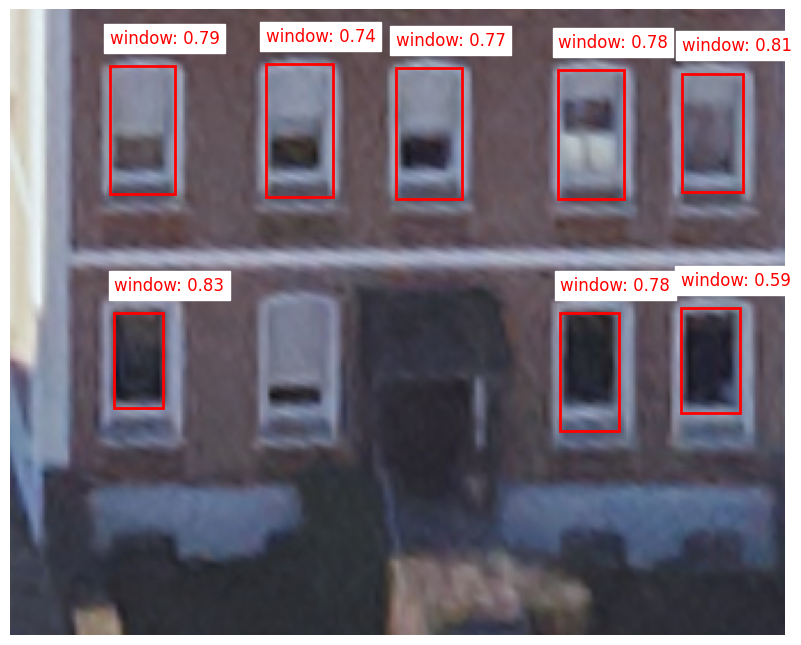

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the correct device
model = model.to(device)
# Define the path to your image
image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3Gt.jpg")

# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
    ])
    return transform(image)

# Load the image
input_image = load_image(image_path).unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)

# Run the model on the image
model.eval()
with torch.no_grad():
    predictions = model(input_image)
    # rich.print("predictions", predictions)

# Visualize the predictions
class_names = ["background", "window"]  # Adjust based on your class names
visualize_predictions(predictions[0], input_image[0], threshold=0.5, class_names=class_names)